In [4]:
import matplotlib.pyplot as plt

from timeseries_ml_utils.data import *
from timeseries_ml_utils.encoders import *
from scipy.stats import linregress
from numpy.random.mtrand import RandomState

# fetch data
data = DataFetcher(["GLD.US"], limit=350)
data.fetch_data().tail()

print(len(data.get_dataframe()))


350


,GLD.US.Open,GLD.US.High,GLD.US.Low,GLD.US.Close,GLD.US.Volume
Date,,,,,
2018-12-10,117.70,117.94,117.420,117.68,8118110
2018-12-11,117.67,117.89,117.350,117.54,6395391
2018-12-12,117.70,117.95,117.612,117.79,4136781
2018-12-13,117.54,117.62,117.260,117.53,4131770
2018-12-14,116.63,117.30,116.580,117.06,7501660


In [21]:
def slope_encoder(y, ref, encode):
    if encode:
        x = np.arange(0, len(y))
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        vec = np.zeros(len(y))
        vec[0] = slope
        return vec
    else:
        slope = y[0]
        return np.array([ref + slope * i for i in range(len(y))])


def batch_predictor(batch):
    return np.array([sample[-1] for sample in batch])


slope_encoder(np.array([10, 20, 30, 40]), 0, True)
slope_encoder(np.array([10, 20, 30, 40]), 10, False)


array([10, 20, 30, 40])

In [23]:
model_data = DataGenerator(data.get_dataframe(),  
                           {"Close$": slope_encoder}, 
                           {"Close$": slope_encoder},
                           lstm_memory_size=1, aggregation_window_size=16, batch_size=10, 
                           model_filename="/tmp/lin_reg_1.h5")


In [25]:
backtest = model_data.back_test(batch_predictor)


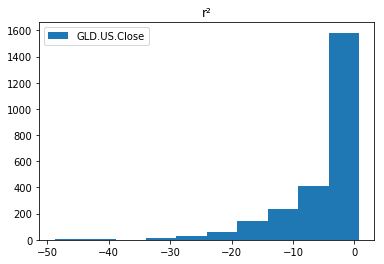

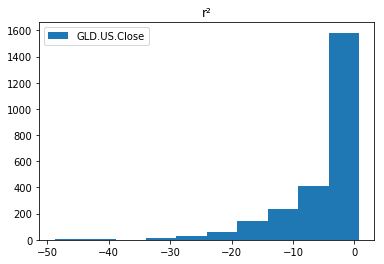

In [45]:
backtest.set_confidence(0.5)
# backtest.plot_random_sample()
backtest.hist()

In [2]:
ref_value_decoders = [(col, lambda x, ref, _: np.repeat(ref, len(x))) for col, _ in model_data.labels]
x = model_data.back_test(lambda x: x[:, -1], ref_value_decoders)

In [1]:
x.set_confidence(.80)
x.plot_random_sample()

NameError: name 'x' is not defined

In [112]:
# mock a lstm 1 aggregation 1 log return model using same seeded random numbers. check confusion Matrix
sigma = 0.006083740376442096  # (np.log(data.get_dataframe()["GLD.US.Close"]) - np.log(data.get_dataframe()["GLD.US.Close"].shift(1))).std()

rand = RandomState()


def log_return_encoder(y, ref, is_encoding):
    if is_encoding:
        return np.log(y / ref)
    else:
        return np.exp(y) * ref


def batch_log_return_predictor(batch):
    return np.array([np.array([[rand.lognormal(0, sigma) - 1.0]]) for _ in batch])


model_logreturn = DataGenerator(data.get_dataframe(),  
                                {"Close$": log_return_encoder}, 
                                {"Close$": log_return_encoder},
                                lstm_memory_size=1, aggregation_window_size=1, batch_size=1, 
                                model_filename="/tmp/log_normal_1.h5")


In [114]:
backtest_log_return = model_logreturn.back_test(batch_log_return_predictor)


In [117]:
backtest_log_return.confusion_matrix()

{'GLD.US.Close': array([[66, 70],
        [59, 85]])}

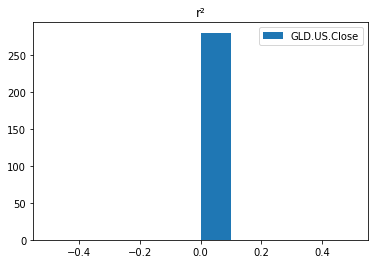

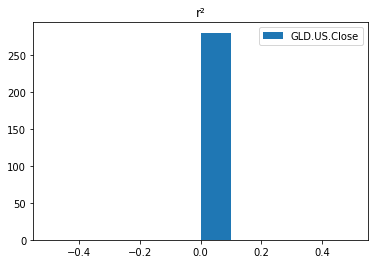

In [121]:
backtest_log_return.hist()